In [2]:
import pandas as pd

# Load the dataset
file_path = 'water_potability.csv'
data = pd.read_csv(file_path)

# Display the dataset
data_info = data.info()
data_head = data.head()

data_info, data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


(None,
          ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
 0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
 1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
 2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
 3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
 4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   
 
    Organic_carbon  Trihalomethanes  Turbidity  Potability  
 0       10.379783        86.990970   2.963135           0  
 1       15.180013        56.329076   4.500656           0  
 2       16.868637        66.420093   3.055934           0  
 3       18.436524       100.341674   4.628771           0  
 4       11.558279        31.997993   4.075075           0  )

In [3]:
# Check for missing values in each column
missing_values = data.isnull().sum()
missing_values_percentage = (missing_values / len(data)) * 100

missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_values_percentage})
missing_data[missing_data['Missing Values'] > 0]

,Missing Values,Percentage
ph,491,14.987790
Sulfate,781,23.840049
Trihalomethanes,162,4.945055


In [4]:
# Split the dataset into two groups based on 'Potability'
potable_water = data[data['Potability'] == 1]
non_potable_water = data[data['Potability'] == 0]

# Checking the split datasets
split_summary = {
    "Potable Water Dataset Size": potable_water.shape,
    "Non-Potable Water Dataset Size": non_potable_water.shape
}

split_summary

{'Potable Water Dataset Size': (1278, 10),
 'Non-Potable Water Dataset Size': (1998, 10)}

In [8]:
# Filling missing values with the median for each group
potable_water_filled = potable_water.fillna(potable_water.median())
non_potable_water_filled = non_potable_water.fillna(non_potable_water.median())

# Check if missing values are filled
potable_missing_after = potable_water_filled.isnull().sum().sum()
non_potable_missing_after = non_potable_water_filled.isnull().sum().sum()

filling_summary = {
    "Potable Water Missing Values After Filling": potable_missing_after,
    "Non-Potable Water Missing Values After Filling": non_potable_missing_after
}

filling_summary

{'Potable Water Missing Values After Filling': 0,
 'Non-Potable Water Missing Values After Filling': 0}

In [11]:
from scipy.spatial.distance import mahalanobis
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import chi2


def calculate_mahalanobis_distance(df):
    # Calculate the inverse of the covariance matrix
    covariance_matrix = df.cov()
    inv_cov_matrix = sp.linalg.inv(covariance_matrix)

    # Calculate the mean of the data
    mean = df.mean()

    # Calculate the Mahalanobis distance for each observation
    df['Mahalanobis'] = df.apply(lambda row: mahalanobis(row, mean, inv_cov_matrix), axis=1)
    return df

# Calculate Mahalanobis distance for potable water dataset
potable_water_mahalanobis = calculate_mahalanobis_distance(potable_water_filled.drop('Potability', axis=1))
potable_water_mahalanobis.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Mahalanobis
250,9.445130,145.805402,13168.529156,9.444471,310.583374,592.659021,8.606397,77.577460,3.875165,3.899717
251,9.024845,128.096691,19859.676476,8.016423,300.150377,451.143481,14.770863,73.778026,3.985251,2.579549
252,7.036752,169.974849,23403.637304,8.519730,331.838167,475.573562,12.924107,50.861913,2.747313,2.278952
253,6.800119,242.008082,39143.403329,9.501695,187.170714,376.456593,11.432466,73.777275,3.854940,4.444179
254,7.174135,203.408935,20401.102461,7.681806,287.085679,315.549900,14.533510,74.405616,3.939896,1.943439


In [14]:
from scipy.stats import chi2

# Calculate the 95% confidence interval threshold for Mahalanobis distance
confidence_level = 0.95
degrees_of_freedom = potable_water_filled.drop('Potability', axis=1).shape[1]  # Number of features
threshold = chi2.ppf(confidence_level, degrees_of_freedom)

# Identifying outliers in the potable water dataset
potable_outliers = potable_water_mahalanobis[potable_water_mahalanobis['Mahalanobis'] > threshold]
num_potable_outliers = potable_outliers.shape[0]

threshold, num_potable_outliers, potable_outliers.head()

(16.918977604620448,
 0,
 Empty DataFrame
 Columns: [ph, Hardness, Solids, Chloramines, Sulfate, Conductivity, Organic_carbon, Trihalomethanes, Turbidity, Mahalanobis]
 Index: [])

In [17]:
# Calculate Mahalanobis distance for non-potable water dataset
non_potable_water_mahalanobis = calculate_mahalanobis_distance(non_potable_water_filled.drop('Potability', axis=1))

# Identifying outliers in the non-potable water dataset
non_potable_outliers = non_potable_water_mahalanobis[non_potable_water_mahalanobis['Mahalanobis'] > threshold]
num_non_potable_outliers = non_potable_outliers.shape[0]

num_non_potable_outliers, non_potable_outliers.head()

(0,
 Empty DataFrame
 Columns: [ph, Hardness, Solids, Chloramines, Sulfate, Conductivity, Organic_carbon, Trihalomethanes, Turbidity, Mahalanobis]
 Index: [])

In [27]:
from scipy.stats import chi2

# Assuming the PCA and Mahalanobis distance calculation has been done as per previous steps
# Now, we set a significance level to determine the outliers
significance_level = 0.05

# Calculate the threshold value based on the chi-squared distribution
threshold = chi2.ppf(1 - significance_level, df=2)  # Using df=2 for 2 PCA components

# Identify outliers as those with a Mahalanobis distance greater than the threshold
potable_water_outliers = potable_distances_df[potable_distances_df['Mahalanobis Distance'] > threshold]
non_potable_water_outliers = non_potable_distances_df[non_potable_distances_df['Mahalanobis Distance'] > threshold]

# Count the number of outliers detected
num_potable_outliers = potable_water_outliers.shape[0]
num_non_potable_outliers = non_potable_water_outliers.shape[0]

# Output the results
print(f'Number of potable water outliers: {num_potable_outliers}')
print(f'Number of non-potable water outliers: {num_non_potable_outliers}')

# Additionally, if you want to remove the outliers from the original dataset
potable_water_cleaned = potable_water_filled.loc[~potable_water_filled.index.isin(potable_water_outliers.index)]
non_potable_water_cleaned = non_potable_water_filled.loc[~non_potable_water_filled.index.isin(non_potable_water_outliers.index)]

# Print the shapes of the cleaned datasets
print(f'Potable water dataset size after outlier removal: {potable_water_cleaned.shape}')
print(f'Non-potable water dataset size after outlier removal: {non_potable_water_cleaned.shape}')


Number of potable water outliers: 0
Number of non-potable water outliers: 0
Potable water dataset size after outlier removal: (1278, 10)
Non-potable water dataset size after outlier removal: (1998, 10)


In [18]:
# Calculate the 99% confidence interval threshold for Mahalanobis distance
confidence_level_99 = 0.99
threshold_99 = chi2.ppf(confidence_level_99, degrees_of_freedom)

# Identifying outliers for potable and non-potable water datasets at 99% confidence level
potable_outliers_99 = potable_water_mahalanobis[potable_water_mahalanobis['Mahalanobis'] > threshold_99]
non_potable_outliers_99 = non_potable_water_mahalanobis[non_potable_water_mahalanobis['Mahalanobis'] > threshold_99]

num_potable_outliers_99 = potable_outliers_99.shape[0]
num_non_potable_outliers_99 = non_potable_outliers_99.shape[0]

threshold_99, num_potable_outliers_99, num_non_potable_outliers_99, potable_outliers_99.head(), non_potable_outliers_99.head()


(21.665994333461924,
 0,
 0,
 Empty DataFrame
 Columns: [ph, Hardness, Solids, Chloramines, Sulfate, Conductivity, Organic_carbon, Trihalomethanes, Turbidity, Mahalanobis]
 Index: [],
 Empty DataFrame
 Columns: [ph, Hardness, Solids, Chloramines, Sulfate, Conductivity, Organic_carbon, Trihalomethanes, Turbidity, Mahalanobis]
 Index: [])

In [39]:
from scipy.stats import chi2

# Degrees of freedom is the number of components selected by PCA
degrees_of_freedom = 9

# Select a confidence level
confidence_level = 0.95

# Calculate the chi-square threshold value
threshold = chi2.ppf(confidence_level, degrees_of_freedom)

print(f"Threshold for identifying outliers: {threshold}")

# Assuming 'potable_water_distances' and 'non_potable_water_distances'
# are lists of Mahalanobis distances for potable and non-potable water after PCA
potable_outliers = [d for d in potable_water_distances if d > threshold]
non_potable_outliers = [d for d in non_potable_water_distances if d > threshold]

print(f"Number of outliers in potable water: {len(potable_outliers)}")
print(f"Number of outliers in non-potable water: {len(non_potable_outliers)}")


Threshold for identifying outliers: 16.918977604620448
Number of outliers in potable water: 0
Number of outliers in non-potable water: 0


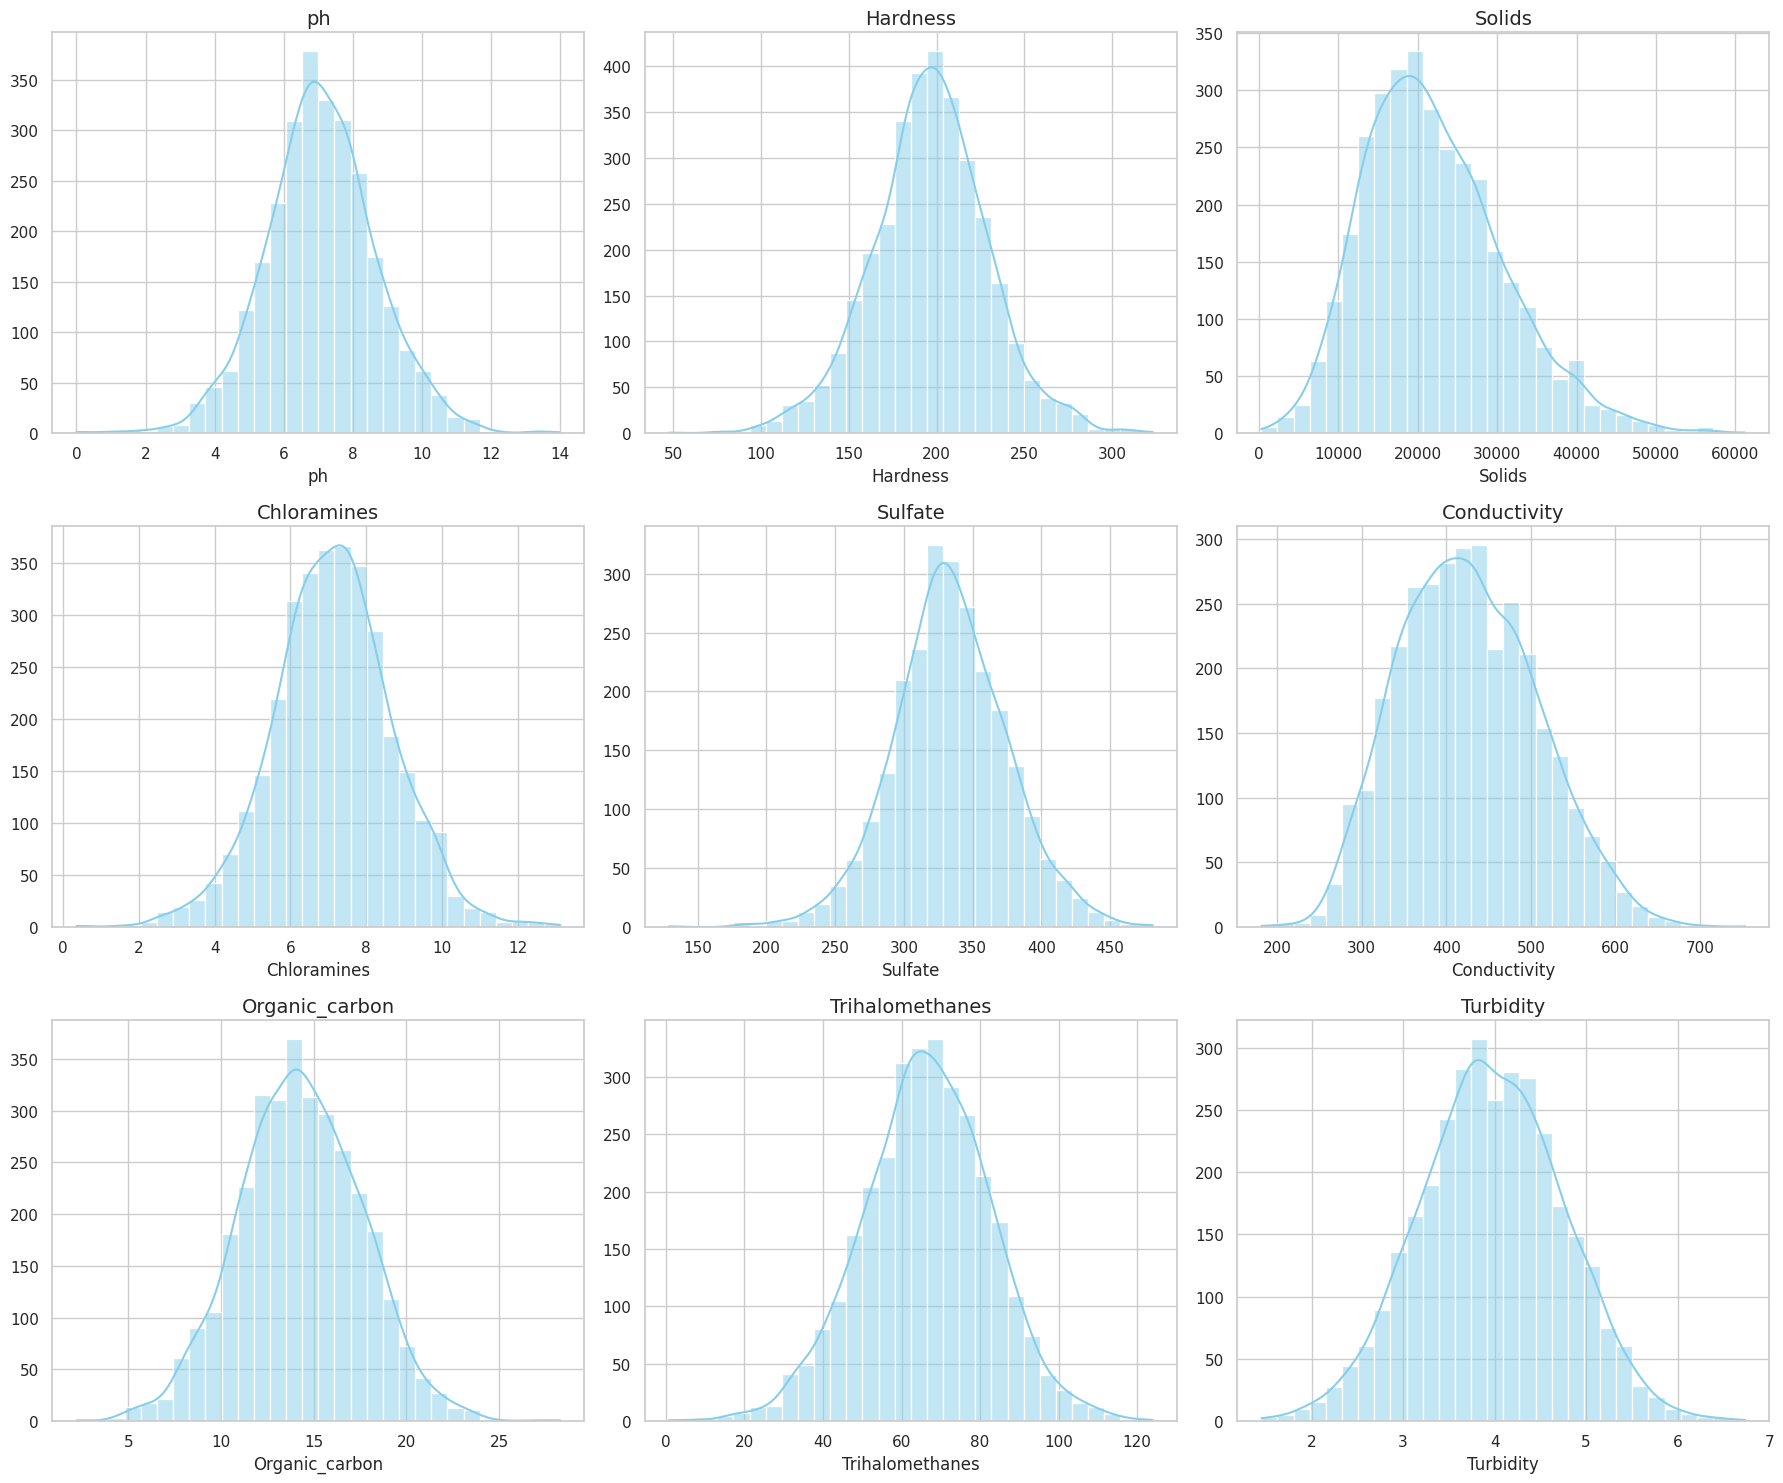

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set(style="whitegrid")

# Creating a figure for multiple subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))

# Flattening the axes array for easy indexing
axes = axes.flatten()

# Plotting histograms for each numeric feature
for i, col in enumerate(data.columns[:-1]):  # Exclude 'Potability' from the plots
    sns.histplot(data[col], ax=axes[i], kde=True, bins=30, color='skyblue')
    axes[i].set_title(col, fontsize=14)
    axes[i].set_ylabel('')

# Adjust layout
plt.tight_layout()
plt.show()

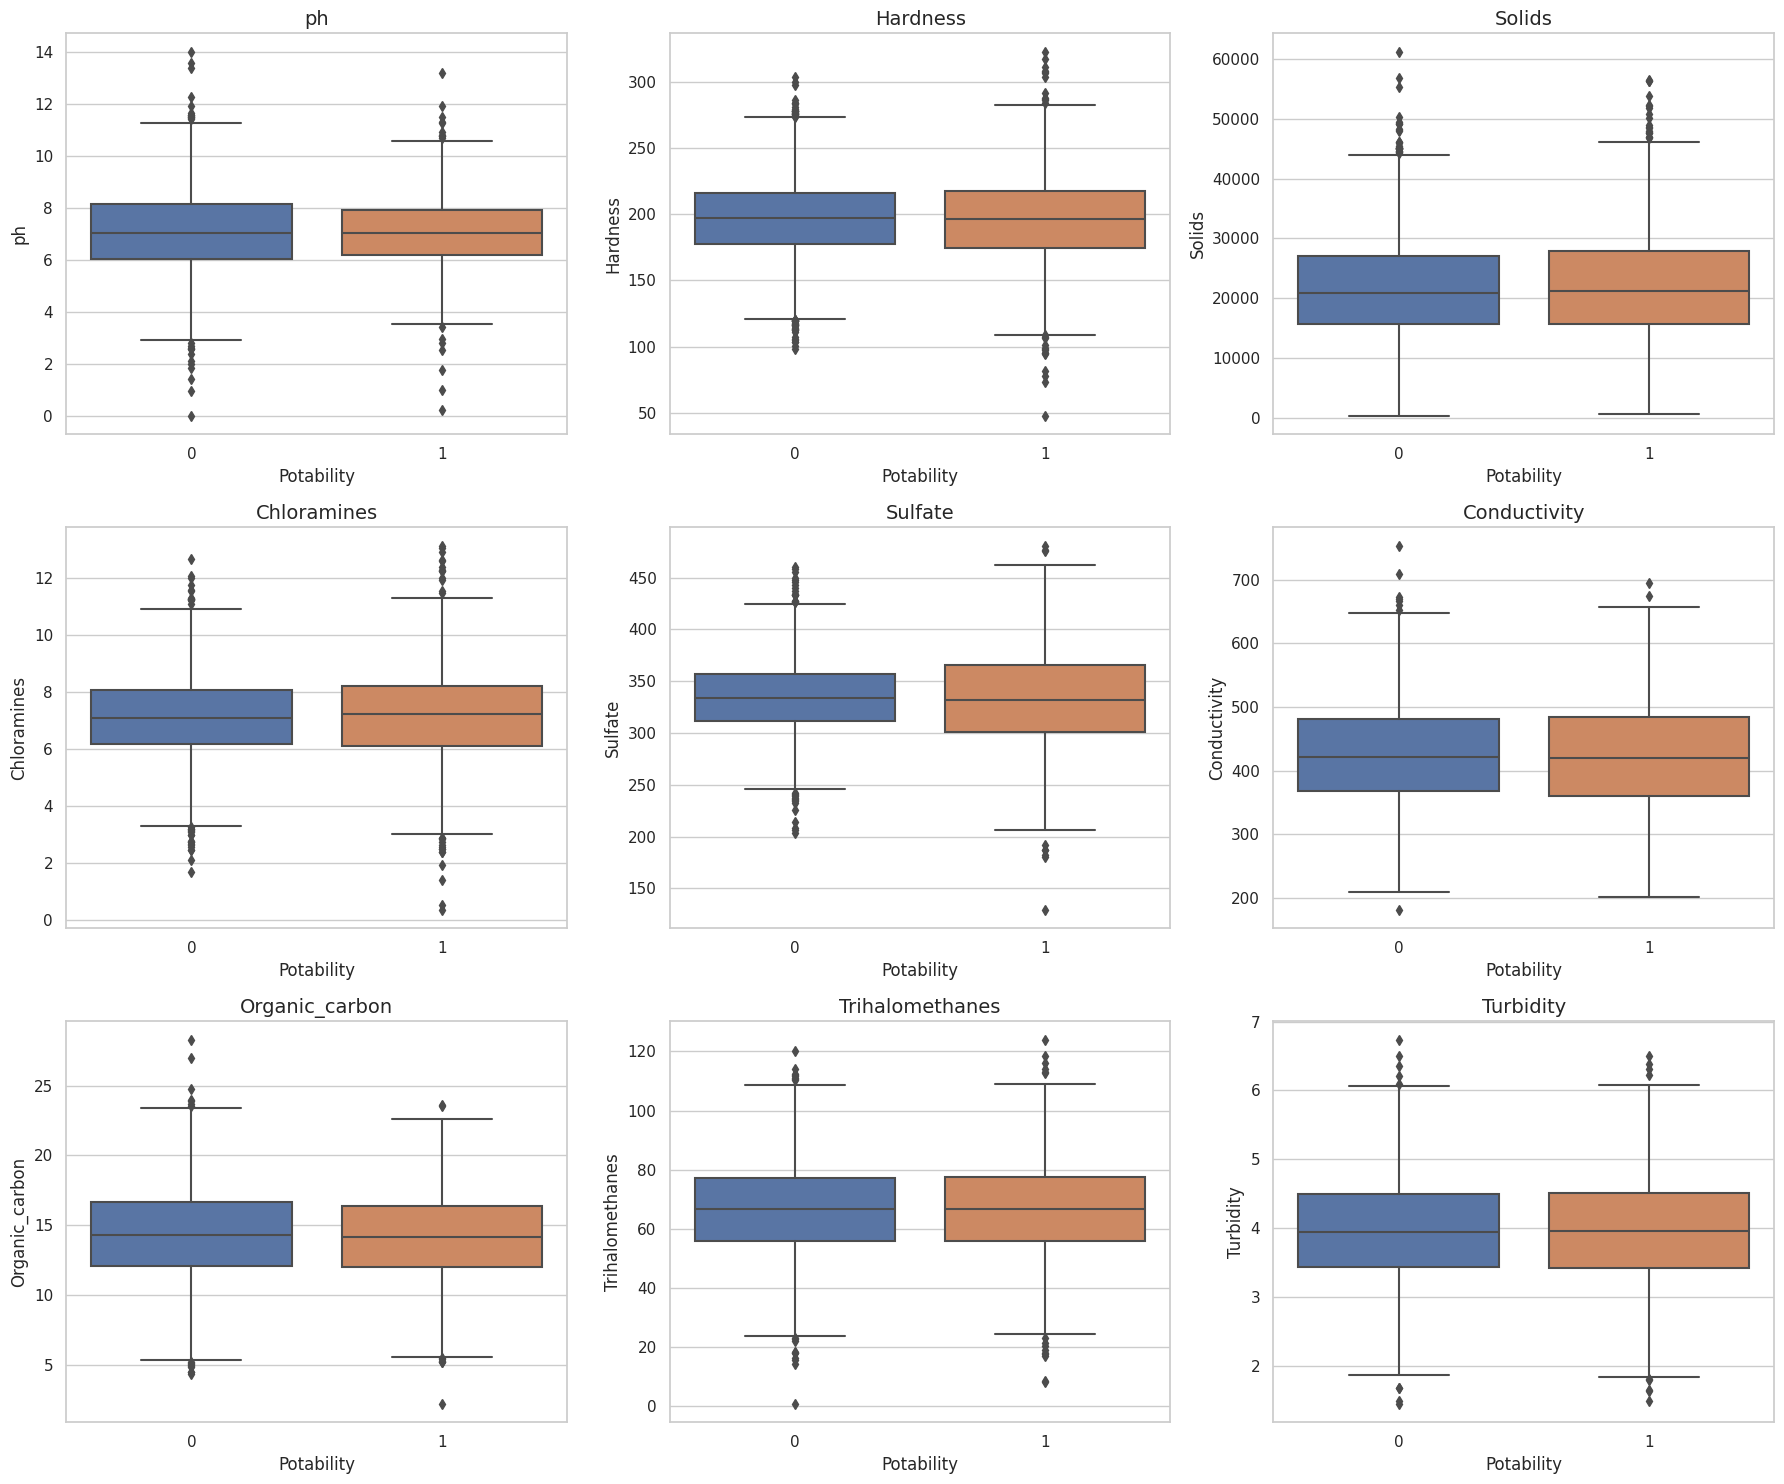

In [ ]:
# Creating a figure for multiple subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))

# Flattening the axes array for easy indexing
axes = axes.flatten()

# Plotting boxplots for each numeric feature
for i, col in enumerate(data.columns[:-1]):  # Exclude 'Potability' from the plots
    sns.boxplot(x='Potability', y=col, data=data, ax=axes[i])
    axes[i].set_title(col, fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()

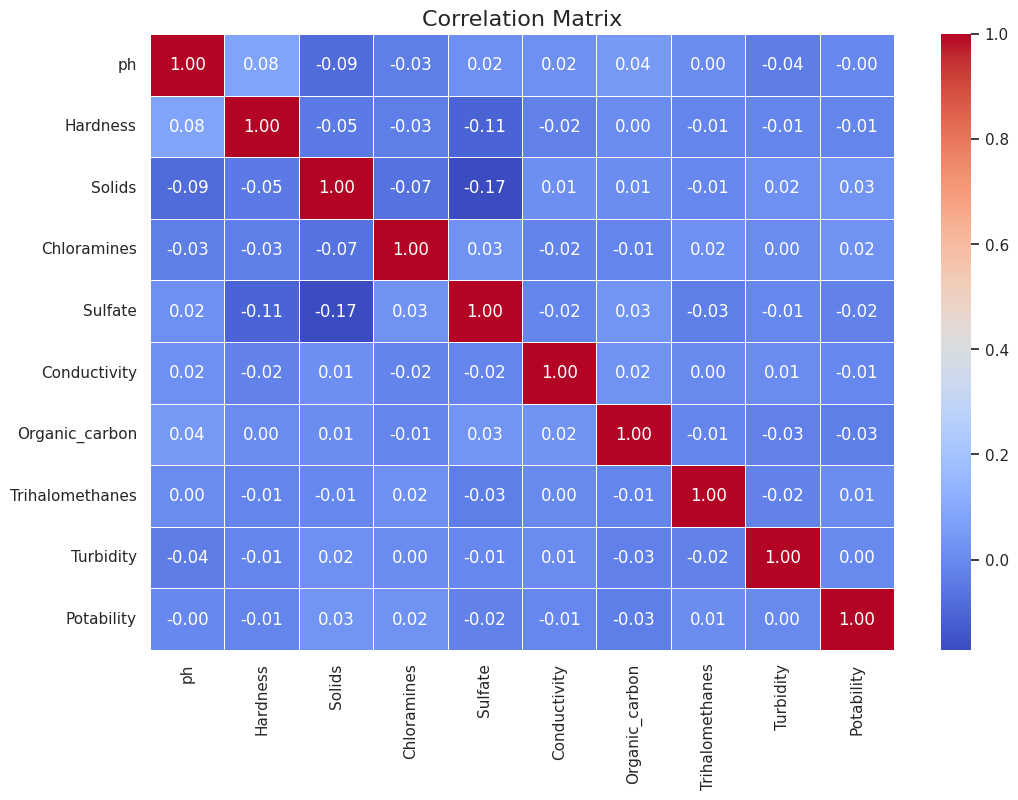

In [ ]:
# Calculate the correlation matrix
corr_matrix = data.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix", fontsize=16)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Filling missing values in the entire dataset with the median
data_filled = data.fillna(data.median())

# Separating the features and the target variable after filling missing values
X_filled = data_filled.drop('Potability', axis=1)
y_filled = data_filled['Potability']

# Splitting the dataset into training and testing sets
X_train_filled, X_test_filled, y_train_filled, y_test_filled = train_test_split(
    X_filled, y_filled, test_size=0.3, random_state=42)

# Initialize the RandomForestClassifier
rf = RandomForestClassifier()

# Fitting the model
rf.fit(X_train_filled, y_train_filled)

# Getting feature importances
feature_importances_filled = rf.feature_importances_

# Creating a DataFrame for feature importances
features_filled = pd.DataFrame({'Feature': X_filled.columns, 'Importance': feature_importances_filled})
features_filled.sort_values(by='Importance', ascending=False, inplace=True)

features_filled


,Feature,Importance
0,ph,0.125899
1,Hardness,0.124651
4,Sulfate,0.117271
3,Chloramines,0.116781
2,Solids,0.116303
6,Organic_carbon,0.104516
5,Conductivity,0.102524
7,Trihalomethanes,0.097808
8,Turbidity,0.094247


In [ ]:
# Defining bins for pH
bins = [0, 6.5, 8.5, 14]
labels = ['Acidic', 'Neutral', 'Alkaline']
data_filled['pH_category'] = pd.cut(data_filled['ph'], bins=bins, labels=labels, include_lowest=True)

# One-hot encoding of the pH categories
pH_dummies = pd.get_dummies(data_filled['pH_category'], prefix='pH')

# Adding the new features to the dataset
data_fe = pd.concat([data_filled, pH_dummies], axis=1)

# Dropping the original and binned pH column
data_fe.drop(['ph', 'pH_category'], axis=1, inplace=True)

# Display the first few rows of the updated dataset
data_fe.head()

,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,pH_Acidic,pH_Neutral,pH_Alkaline
0,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0,0,1,0
1,129.422921,18630.05786,6.635246,333.073546,592.885359,15.180013,56.329076,4.500656,0,1,0,0
2,224.236259,19909.54173,9.275884,333.073546,418.606213,16.868637,66.420093,3.055934,0,0,1,0
3,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0,0,1,0
4,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0,0,0,1


In [ ]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

# Log transformation of the 'Solids' feature
data_fe['Solids_log'] = np.log(data_fe['Solids'])

# Creating an interaction feature between 'Organic_carbon' and 'Trihalomethanes'
data_fe['Organic_Trihalomethanes'] = data_fe['Organic_carbon'] * data_fe['Trihalomethanes']

# Selecting features for polynomial transformation
features_for_poly = ['Hardness', 'Chloramines', 'Sulfate']

# Initializing the PolynomialFeatures object
poly = PolynomialFeatures(degree=2, include_bias=False)

# Fitting and transforming the selected features
poly_features = poly.fit_transform(data_fe[features_for_poly])

# Creating a DataFrame for the polynomial features
poly_feature_names = [f'poly_{i}' for i in range(poly_features.shape[1])]
poly_features_df = pd.DataFrame(poly_features, columns=poly_feature_names)

# Merging the polynomial features with the main dataset
data_fe = pd.concat([data_fe, poly_features_df], axis=1)

# Dropping the original features used for polynomial transformation
data_fe.drop(features_for_poly, axis=1, inplace=True)

# Display the first few rows of the updated dataset
data_fe.head()

,Solids,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,pH_Acidic,pH_Neutral,pH_Alkaline,Solids_log,Organic_Trihalomethanes,poly_0,poly_1,poly_2,poly_3,poly_4,poly_5,poly_6,poly_7,poly_8
0,20791.31898,564.308654,10.379783,86.990970,2.963135,0,0,1,0,9.942291,902.947403,204.890456,7.300212,368.516441,41980.098755,1495.743736,75505.501517,53.293093,2690.248100,135804.367508
1,18630.05786,592.885359,15.180013,56.329076,4.500656,0,1,0,0,9.832532,855.076117,129.422921,6.635246,333.073546,16750.292351,858.752901,43107.351026,44.026488,2210.024873,110937.986845
2,19909.54173,418.606213,16.868637,66.420093,3.055934,0,0,1,0,9.898954,1120.416425,224.236259,9.275884,333.073546,50281.900030,2079.989442,74687.165993,86.042017,3089.551441,110937.986845
3,22018.41744,363.266516,18.436525,100.341674,4.628771,0,0,1,0,9.999635,1849.951738,214.373394,8.059332,356.886136,45955.952098,1727.706436,76506.892196,64.952838,2876.263988,127367.713784
4,17978.98634,398.410813,11.558279,31.997993,4.075075,0,0,0,1,9.796959,369.841741,181.101509,6.546600,310.135738,32797.756635,1185.599135,56166.050118,42.857971,2030.334611,96184.175675


In [ ]:
from sklearn.preprocessing import StandardScaler

# Separating the features and the target variable for preprocessing
X_fe = data_fe.drop('Potability', axis=1)
y_fe = data_fe['Potability']

# Initializing the StandardScaler
scaler = StandardScaler()

# Fitting the scaler to the features and transforming them
X_fe_scaled = scaler.fit_transform(X_fe)

# Checking the class distribution of the target variable
class_distribution = y_fe.value_counts()

class_distribution

0    1998
1    1278
Name: Potability, dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE

# Initializing SMOTE
smote = SMOTE(random_state=42)

# Fitting SMOTE and resampling the dataset
X_fe_resampled, y_fe_resampled = smote.fit_resample(X_fe_scaled, y_fe)

# Checking the new class distribution
new_class_distribution = pd.Series(y_fe_resampled).value_counts()

new_class_distribution

0    1998
1    1998
Name: Potability, dtype: int64

In [ ]:
from sklearn.utils import resample

# Separating the majority and minority classes
majority_class = data_fe[y_fe == 0]
minority_class = data_fe[y_fe == 1]

# Upsampling the minority class
minority_upsampled = resample(minority_class,
                              replace=True,                # sample with replacement
                              n_samples=len(majority_class), # to match majority class
                              random_state=42)             # reproducible results

# Combining majority class with upsampled minority class
upsampled_data = pd.concat([majority_class, minority_upsampled])

# Checking the new class distribution
upsampled_class_distribution = upsampled_data['Potability'].value_counts()

upsampled_class_distribution

0    1998
1    1998
Name: Potability, dtype: int64

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Splitting the upsampled data into features and target
X_upsampled = upsampled_data.drop('Potability', axis=1)
y_upsampled = upsampled_data['Potability']

# Splitting the upsampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_upsampled, y_upsampled, test_size=0.3, random_state=42)

# Initializing the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Fitting the model to the training data
rf_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluating the model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_classification_report = classification_report(y_test, y_pred_rf)

rf_accuracy, rf_classification_report

(0.8215179316096747,
 '              precision    recall  f1-score   support\n\n           0       0.82      0.84      0.83       617\n           1       0.82      0.80      0.81       582\n\n    accuracy                           0.82      1199\n   macro avg       0.82      0.82      0.82      1199\nweighted avg       0.82      0.82      0.82      1199\n')

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initializing the Logistic Regression model
lr_model = LogisticRegression(random_state=42)

# Fitting the model to the training data
lr_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_lr = lr_model.predict(X_test)

# Evaluating the model
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_classification_report = classification_report(y_test, y_pred_lr)

lr_accuracy, lr_classification_report

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.53628023352794,
 '              precision    recall  f1-score   support\n\n           0       0.54      0.62      0.58       617\n           1       0.53      0.45      0.48       582\n\n    accuracy                           0.54      1199\n   macro avg       0.53      0.53      0.53      1199\nweighted avg       0.54      0.54      0.53      1199\n')

In [ ]:
from sklearn.neural_network import MLPClassifier

# Initializing the ANN model
ann_model = MLPClassifier(random_state=42)

# Fitting the model to the training data
ann_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_ann = ann_model.predict(X_test)

# Evaluating the model
ann_accuracy = accuracy_score(y_test, y_pred_ann)
ann_classification_report = classification_report(y_test, y_pred_ann)
ann_accuracy, ann_classification_report

(0.5437864887406172,
 '              precision    recall  f1-score   support\n\n           0       0.54      0.81      0.65       617\n           1       0.56      0.26      0.36       582\n\n    accuracy                           0.54      1199\n   macro avg       0.55      0.54      0.50      1199\nweighted avg       0.55      0.54      0.51      1199\n')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Initializing the KNN model
knn_model = KNeighborsClassifier()

# Fitting the model to the training data
knn_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_knn = knn_model.predict(X_test)

# Evaluating the model
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_classification_report = classification_report(y_test, y_pred_knn)
knn_accuracy, knn_classification_report

(0.6263552960800667,
 '              precision    recall  f1-score   support\n\n           0       0.66      0.58      0.61       617\n           1       0.60      0.68      0.64       582\n\n    accuracy                           0.63      1199\n   macro avg       0.63      0.63      0.63      1199\nweighted avg       0.63      0.63      0.63      1199\n')

In [ ]:
from sklearn.svm import SVC

# Initializing the Support Vector Machine model
svm_model = SVC(random_state=42)

# Fitting the model to the training data
svm_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_svm = svm_model.predict(X_test)

# Evaluating the model
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_classification_report = classification_report(y_test, y_pred_svm)
svm_accuracy, svm_classification_report

(0.5629691409507923,
 '              precision    recall  f1-score   support\n\n           0       0.55      0.87      0.67       617\n           1       0.63      0.24      0.35       582\n\n    accuracy                           0.56      1199\n   macro avg       0.59      0.55      0.51      1199\nweighted avg       0.59      0.56      0.51      1199\n')

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Initializing the Gradient Boosting Classifier
gbm_model = GradientBoostingClassifier(random_state=42)

# Fitting the model to the training data
gbm_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred_gbm = gbm_model.predict(X_test)

# Evaluating the model
gbm_accuracy = accuracy_score(y_test, y_pred_gbm)
gbm_classification_report = classification_report(y_test, y_pred_gbm)
gbm_accuracy, gbm_classification_report

(0.6688907422852377,
 '              precision    recall  f1-score   support\n\n           0       0.65      0.76      0.70       617\n           1       0.69      0.58      0.63       582\n\n    accuracy                           0.67      1199\n   macro avg       0.67      0.67      0.66      1199\nweighted avg       0.67      0.67      0.67      1199\n')

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_clf.predict(X_test)

# Calculate the accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Model Accuracy:", accuracy_xgb)


XGBoost Model Accuracy: 0.7848206839032527


In [ ]:
# Random Forest on training set
rf_train_predictions = rf_model.predict(X_train)
rf_train_accuracy = accuracy_score(y_train, rf_train_predictions)

# Random Forest on testing set
rf_test_predictions = rf_model.predict(X_test)
rf_test_accuracy = accuracy_score(y_test, rf_test_predictions)

print("Random Forest Training Accuracy:", rf_train_accuracy)
print("Random Forest Testing Accuracy:", rf_test_accuracy)

Random Forest Training Accuracy: 1.0
Random Forest Testing Accuracy: 0.8215179316096747


In [ ]:
# XGBoost model performance on the training set
xgb_train_predictions = xgb_clf.predict(X_train)
xgb_train_accuracy = accuracy_score(y_train, xgb_train_predictions)

# XGBoost model performance on the test set
xgb_test_predictions = xgb_clf.predict(X_test)
xgb_test_accuracy = accuracy_score(y_test, xgb_test_predictions)

print("XGBoost Training Accuracy:", xgb_train_accuracy)
print("XGBoost Testing Accuracy:", xgb_test_accuracy)


XGBoost Training Accuracy: 0.9992849481587415
XGBoost Testing Accuracy: 0.7848206839032527


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Adjusted parameters include the number of trees (n_estimators), the maximum depth of the tree (max_depth)
# and the minimum number of samples required for node splitting (min_samples_split)
rf_model_tuned = RandomForestClassifier(
    n_estimators=100,      # Try to reduce the number of trees
    max_depth=10,          # Limit the maximum depth of the tree
    min_samples_split=4,   # Increase the minimum number of samples required for node partitioning
    random_state=42
)

# Train the model with training set data
rf_model_tuned.fit(X_train, y_train)

# Evaluate model performance on training and test sets
rf_train_accuracy_tuned = rf_model_tuned.score(X_train, y_train)
rf_test_accuracy_tuned = rf_model_tuned.score(X_test, y_test)

print("Tuned Random Forest Training Accuracy:", rf_train_accuracy_tuned)
print("Tuned Random Forest Testing Accuracy:", rf_test_accuracy_tuned)

Tuned Random Forest Training Accuracy: 0.918484090096532
Tuned Random Forest Testing Accuracy: 0.7648040033361134


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search for best parameters
param_grid = {
    'max_depth': [3, 5, 7],  # Lower values to prevent the model from learning overly complex patterns
    'min_child_weight': [1, 3, 5],  # Helps in preventing overfitting
    'subsample': [0.5, 0.7, 1],  # Lower values can prevent overfitting but too low can lead to underfitting
    'colsample_bytree': [0.5, 0.7, 1],  # Similar to subsample but for features
    'n_estimators': [100, 200, 300],  # Number of trees (can be adjusted based on your computational resources)
    'learning_rate': [0.01, 0.1, 0.2]  # Lower learning rate can lead to better generalization
}

# Initialize the XGBoost classifier
xgb_optimized = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_optimized, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to find the best parameters
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the model with the best parameters
xgb_optimized.set_params(**best_params)
xgb_optimized.fit(X_train, y_train)

# Evaluate the optimized model
optimized_train_predictions = xgb_optimized.predict(X_train)
optimized_train_accuracy = accuracy_score(y_train, optimized_train_predictions)
optimized_test_predictions = xgb_optimized.predict(X_test)
optimized_test_accuracy = accuracy_score(y_test, optimized_test_predictions)

print("Optimized XGBoost Training Accuracy:", optimized_train_accuracy)
print("Optimized XGBoost Testing Accuracy:", optimized_test_accuracy)


Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1}
Optimized XGBoost Training Accuracy: 0.9992849481587415
Optimized XGBoost Testing Accuracy: 0.7898248540450375


In [ ]:
from sklearn.model_selection import cross_val_score

# Evaluate random forest models using cross-validation
rf_cross_val_scores = cross_val_score(rf_model_tuned, X_upsampled, y_upsampled, cv=5)

print("Random Forest Cross Validation Scores:", rf_cross_val_scores)
print("Mean Accuracy:", rf_cross_val_scores.mean())
print("Accuracy Standard Deviation:", rf_cross_val_scores.std())

Random Forest Cross Validation Scores: [0.70375    0.78848561 0.75219024 0.69336671 0.77221527]
Mean Accuracy: 0.7420015644555695
Accuracy Standard Deviation: 0.037432538338519256


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}

# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, n_jobs=-1, scoring='accuracy')

# Fit GridSearchCV
grid_search_rf.fit(X_train, y_train)

# Best parameters
best_params_rf = grid_search_rf.best_params_
print("Best Parameters for Random Forest:", best_params_rf)


Best Parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 300}


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Parameter grid for Gradient Boosting
param_grid_gbm = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0]
}

# Initialize Gradient Boosting Classifier
gbm = GradientBoostingClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_gbm = GridSearchCV(estimator=gbm, param_grid=param_grid_gbm, cv=5, n_jobs=-1, scoring='accuracy')

# Fit GridSearchCV
grid_search_gbm.fit(X_train, y_train)

# Best parameters
best_params_gbm = grid_search_gbm.best_params_
print("Best Parameters for Gradient Boosting Machine:", best_params_gbm)


Best Parameters for Gradient Boosting Machine: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.7}


retrain

In [ ]:
# Re-training the Random Forest model with the best parameters
rf_optimized = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=6,
    min_samples_leaf=1,
    random_state=42
)

rf_optimized.fit(X_train, y_train)

# Evaluating the optimized model on the test set
y_pred_rf_optimized = rf_optimized.predict(X_test)
rf_optimized_accuracy = accuracy_score(y_test, y_pred_rf_optimized)

print("Optimized Random Forest Test Accuracy:", rf_optimized_accuracy)


Optimized Random Forest Test Accuracy: 0.8290241868223519


In [ ]:
# Re-training the Gradient Boosting model with the best parameters
gbm_optimized = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.2,
    max_depth=7,
    subsample=0.7,
    random_state=42
)

gbm_optimized.fit(X_train, y_train)

# Evaluating the optimized model on the test set
y_pred_gbm_optimized = gbm_optimized.predict(X_test)
gbm_optimized_accuracy = accuracy_score(y_test, y_pred_gbm_optimized)

print("Optimized Gradient Boosting Machine Test Accuracy:", gbm_optimized_accuracy)


Optimized Gradient Boosting Machine Test Accuracy: 0.7956630525437864


Further Evaluation


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Confusion Matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf_optimized)
print("Random Forest Confusion Matrix:\n", conf_matrix_rf)

# Classification Report (Precision, Recall, F1-Score)
class_report_rf = classification_report(y_test, y_pred_rf_optimized)
print("\nRandom Forest Classification Report:\n", class_report_rf)


Random Forest Confusion Matrix:
 [[512 105]
 [100 482]]

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.83      0.83       617
           1       0.82      0.83      0.82       582

    accuracy                           0.83      1199
   macro avg       0.83      0.83      0.83      1199
weighted avg       0.83      0.83      0.83      1199



In [ ]:
# Confusion Matrix for Gradient Boosting Machine
conf_matrix_gbm = confusion_matrix(y_test, y_pred_gbm_optimized)
print("Gradient Boosting Machine Confusion Matrix:\n", conf_matrix_gbm)

# Classification Report (Precision, Recall, F1-Score)
class_report_gbm = classification_report(y_test, y_pred_gbm_optimized)
print("\nGradient Boosting Machine Classification Report:\n", class_report_gbm)


Gradient Boosting Machine Confusion Matrix:
 [[478 139]
 [106 476]]

Gradient Boosting Machine Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.77      0.80       617
           1       0.77      0.82      0.80       582

    accuracy                           0.80      1199
   macro avg       0.80      0.80      0.80      1199
weighted avg       0.80      0.80      0.80      1199



Statistical Analysis of Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

# Assuming rf_test_predictions and y_test are your model predictions and actual labels
conf_matrix_rf = confusion_matrix(y_test, rf_test_predictions)

# Extracting TP, TN, FP, FN from the confusion matrix
TN, FP, FN, TP = conf_matrix_rf.ravel()

# Calculating False Positive Rate (FPR) and False Negative Rate (FNR)
FPR = FP / (FP + TN)  # False Positive Rate = FP / (FP + TN)
FNR = FN / (FN + TP)  # False Negative Rate = FN / (TP + FN)

print("Confusion Matrix:\n", conf_matrix_rf)
print("False Positive Rate:", FPR)
print("False Negative Rate:", FNR)


Confusion Matrix:
 [[517 100]
 [114 468]]
False Positive Rate: 0.1620745542949757
False Negative Rate: 0.1958762886597938


Feature Importance Analysis for Random Forest Model

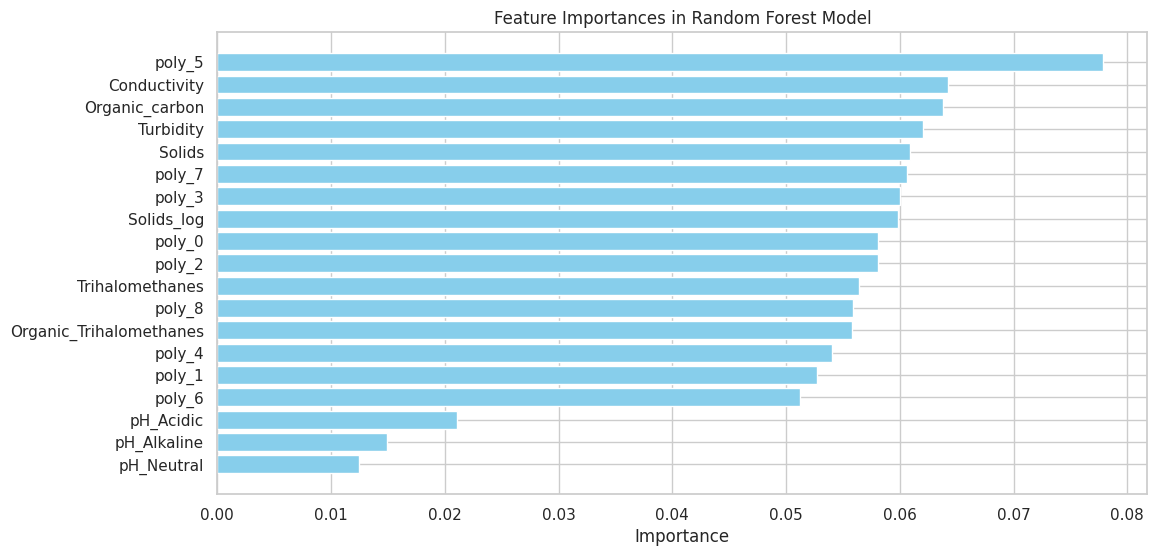

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Extracting feature importances from the Random Forest model
feature_importances = rf_optimized.feature_importances_

# Creating a DataFrame to display these importances
features = X_train.columns
importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sorting the DataFrame based on importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(12, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances in Random Forest Model')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()


In [ ]:
# Assuming 'features_for_poly' contains the original feature names ['Hardness', 'Chloramines', 'Sulfate']
features_for_poly = ['Hardness', 'Chloramines', 'Sulfate']

# Manually create the polynomial feature names for degree 2
poly_feature_names_manual = (
    [f'{feature}^2' for feature in features_for_poly] +  # Squared terms
    [f'{features_for_poly[i]}*{features_for_poly[j]}' for i in range(len(features_for_poly)) for j in range(i+1, len(features_for_poly))]  # Interaction terms
)

# Match 'poly_5' to the correct feature name from poly_feature_names_manual
poly_5_name_manual = poly_feature_names_manual[5]
print(poly_5_name_manual)



Chloramines*Sulfate
